# Price Exploration

In [110]:
# NOTE: import ccxt.async_support as ccxt
from web3 import Web3
from dotenv import load_dotenv
import ccxt
import os
import pandas as pd
from datetime import datetime
import numpy as np

# Chainlink

We could use Chainlink, but probably okay and more convenient to use ccxt for "true" prices. Chainlink is especially annoying since you have to specify rounds instead of timestamps.

In [107]:
load_dotenv()
INFURA_KEY = os.getenv("INFURA_KEY")

# Change this to use your own RPC URL
web3 = Web3(Web3.HTTPProvider(f"https://mainnet.infura.io/v3/{INFURA_KEY}"))

# AggregatorV3Interface ABI
abi = '[{"inputs":[],"name":"decimals","outputs":[{"internalType":"uint8","name":"","type":"uint8"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"description","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint80","name":"_roundId","type":"uint80"}],"name":"getRoundData","outputs":[{"internalType":"uint80","name":"roundId","type":"uint80"},{"internalType":"int256","name":"answer","type":"int256"},{"internalType":"uint256","name":"startedAt","type":"uint256"},{"internalType":"uint256","name":"updatedAt","type":"uint256"},{"internalType":"uint80","name":"answeredInRound","type":"uint80"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"latestRoundData","outputs":[{"internalType":"uint80","name":"roundId","type":"uint80"},{"internalType":"int256","name":"answer","type":"int256"},{"internalType":"uint256","name":"startedAt","type":"uint256"},{"internalType":"uint256","name":"updatedAt","type":"uint256"},{"internalType":"uint80","name":"answeredInRound","type":"uint80"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"version","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"}]'
# Price Feed address
addr = '0x8fFfFfd4AfB6115b954Bd326cbe7B4BA576818f6'

addr = web3.to_checksum_address(addr)

# Set up contract instance
contract = web3.eth.contract(address=addr, abi=abi)

#  Valid roundId must be known. They are NOT incremental.
valid_round_id = 36893488147419104482
# valid_round_id = 0

sample = contract.functions.getRoundData(valid_round_id).call()
decimals = contract.functions.decimals().call()
print(sample[1]/10**decimals)
# contract.functions.latestRoundData().call()

1.00012638


# Using CCXT

Thought: create a stack of excahnges and try getting USD/ETH (depending on peg) prices for each of them. If getting prices fails, pop from the stack and try on the next exchange (e.g. binanceus, binance, coinbase, kraken, etc..)

In [65]:
start = datetime(2023, 3, 1)
end = datetime(2023, 4, 1)
start_ts = int(datetime.timestamp(start))*1000
end_ts = int(datetime.timestamp(end))*1000
print(f"Fetching data from {start} to {end}")

Fetching data from 2023-03-01 00:00:00 to 2023-04-01 00:00:00


In [113]:
exchange=ccxt.binanceus()
symbol = 'USDC/USD'
timeframe = '1m'
limit = 1000 # imposed by binanceus?
df = pd.DataFrame()
since = start_ts
while since < end_ts:
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit, since=since)
    df_temp = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df_temp['datetime'] = pd.to_datetime(df_temp['timestamp'], unit='ms')
    df_temp.set_index('datetime', inplace=True)
    df = pd.concat([df, df_temp])
    since = int(df.index[-1].timestamp() * 1000)+1 # Update

df

,timestamp,open,high,low,close,volume
datetime,,,,,,
2023-03-01 05:00:00,1677646800000,1.0001,1.0001,1.0001,1.0001,69.74
2023-03-01 05:01:00,1677646860000,1.0001,1.0001,1.0001,1.0001,72.69
2023-03-01 05:02:00,1677646920000,1.0001,1.0003,1.0001,1.0003,76.17
2023-03-01 05:03:00,1677646980000,1.0001,1.0003,1.0001,1.0003,77.41
2023-03-01 05:04:00,1677647040000,1.0000,1.0003,1.0000,1.0003,938.65
...,...,...,...,...,...,...
2023-04-01 10:55:00,1680346500000,1.0000,1.0000,1.0000,1.0000,0.00
2023-04-01 10:56:00,1680346560000,1.0000,1.0000,1.0000,1.0000,0.00
2023-04-01 10:57:00,1680346620000,1.0000,1.0001,1.0000,1.0001,2993.92


<Axes: xlabel='datetime'>

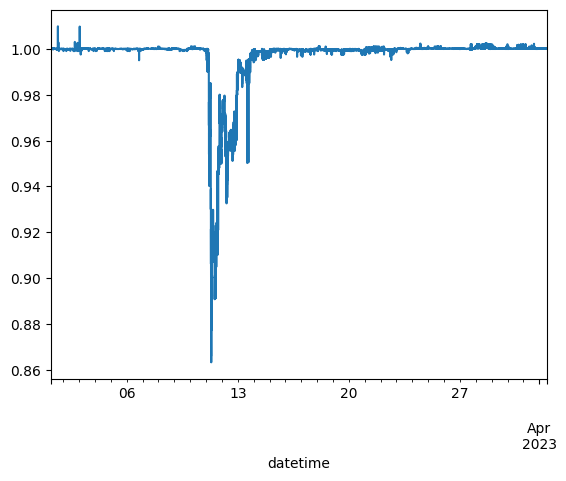

In [114]:
df['close'].plot()

# CCXT Price Vol

<Axes: xlabel='datetime'>

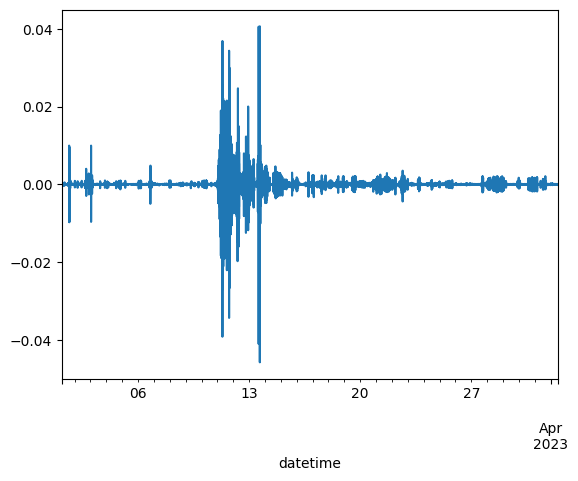

In [117]:
df['returns'] = df['close']/df['close'].shift()
df['log_returns'] = np.log(df['returns'])
df['log_returns'].plot()

<Axes: xlabel='datetime'>

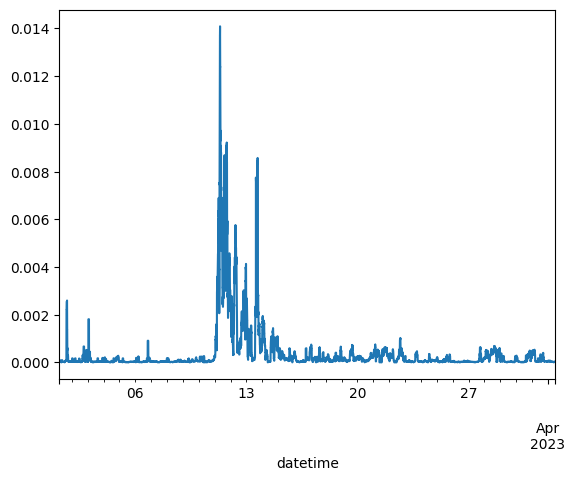

In [137]:
df['log_returns'].rolling(window=60).std().plot()